<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="BS"></a><h1 style="text-align:center;">Hawkes process simulation</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [13]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.point_processes.hawkes import lam_from_jumps, N_from_jumps, U_from_jumps
from notebooks.dev.visualisation import poisson_jumps_test

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hawkes process simulation

In [3]:
# Creating a kernel object
H = 0.3
c = 2
K = FractionalKernel(H=H, c=c)

# Defining a time grid
T = 1
n_steps = 1000
t_grid = np.linspace(0, T, n_steps + 1)

# Define the functions g0 and their integrals
mu = 3

def g0_const(t, mu=mu):
    return mu * np.ones_like(t)

def g0_bar_const(t, mu=mu):
    return mu * t

def g0_bar_res(t, mu=mu):
    return mu * t + mu * K.resolvent.double_integrated_kernel(t)

# Specify simulation details
n_paths = 10

#### The Hawkes iVi scheme

In [4]:
# Create an instance of `IVIHawkesProcess`
ivi_hawkes = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=np.random.default_rng(seed=42), g0=g0_const, resolvent_flag=False)
# Simulate teh trajectories using the iVi scheme
N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)

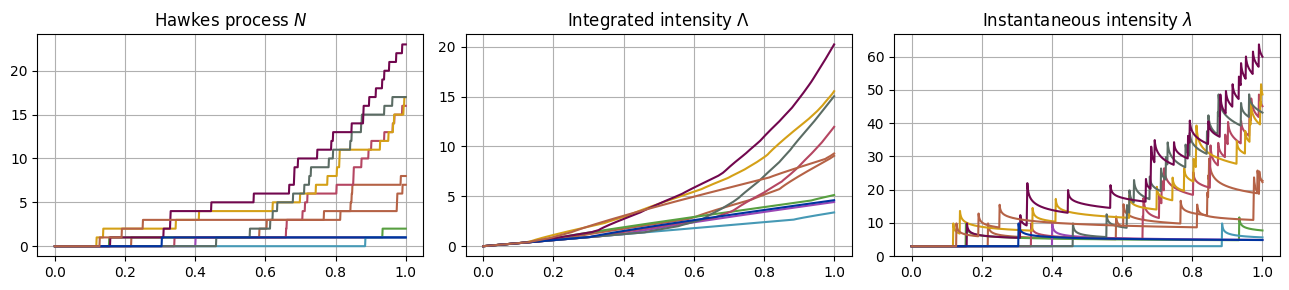

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
n_show = n_paths

ax[0].plot(t_grid, N[:, 0:n_show])
ax[0].set_title('Hawkes process $N$')
ax[0].grid("on")

ax[1].plot(t_grid, U[:,0:n_show])
ax[1].set_title('Integrated intensity $\Lambda$')
ax[1].grid("on")

ax[2].plot(t_grid, lam[:,0:n_show])
ax[2].set_title('Instantaneous intensity $\lambda$')
ax[2].grid("on")

plt.show()

#### The Hawkes Resolvent iVi scheme

In [6]:
# Create an instance of `IVIHawkesProcess`, set `resolvent_flag=True` to use the resolvent version.
# Note than when using the resolvent version, the function `g0_bar_res` should be specified.
# It corresponds to g0_bar_res = g0_bar + R ★ g0_bar.
ivi_hawkes_res = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, g0_bar_res=g0_bar_res, rng=np.random.default_rng(seed=42),
                                  g0=g0_const, resolvent_flag=True)
# Simulate the trajectories using the iVi scheme
N, U, lam = ivi_hawkes_res.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)

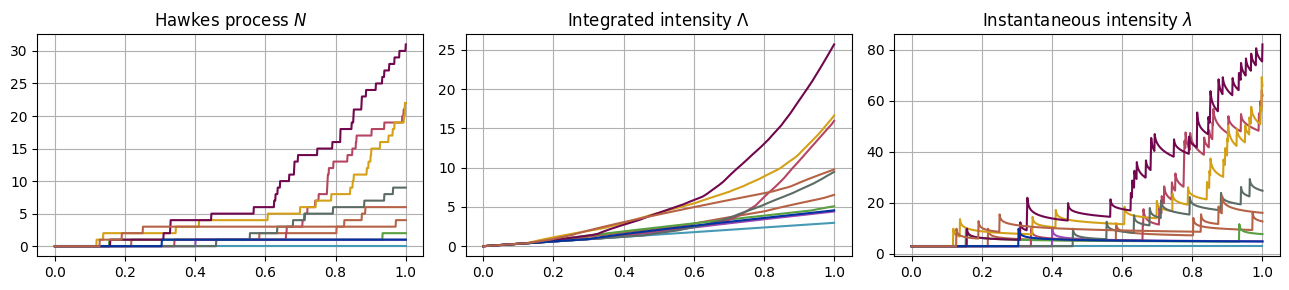

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
n_show = n_paths

ax[0].plot(t_grid, N[:, 0:n_show])
ax[0].set_title('Hawkes process $N$')
ax[0].grid("on")

ax[1].plot(t_grid, U[:,0:n_show])
ax[1].set_title('Integrated intensity $\Lambda$')
ax[1].grid("on")

ax[2].plot(t_grid, lam[:,0:n_show])
ax[2].set_title('Instantaneous intensity $\lambda$')
ax[2].grid("on")

plt.show()

# II. Sanity check: Computing $\mathbb{E}[N_t]$

To check the proposed simulation algorighm, we compute the empirical means over the simulated trajectories of $N$ and $U$.

Note that
$$
\mathbb{E}[N_t] = \mathbb{E}[U_t] =: m_t,  
$$
where $m$ satisfies
$$
m_t = \bar g_0(t) + \int_0^tK(t - s)m_sds,
$$
and hence,
$$
m_t = \bar g_0(t) + \int_0^tR(t - s) g_0(s)ds,
$$
where $R$ is the resolvent of $K$ satisfying
$$
R * K = K * R = R - K.
$$

For instance, the resolvent corresponding to the fractional kernel is given by
$$
R(t) = t^{\alpha - 1} E_{\alpha, \alpha}(t^\alpha), \quad \alpha = H + 0.5,
$$
where $E_{\alpha, \beta}$ denotes the Mittag–Leffler function
$$
E_{\alpha, \beta}(z) = \sum_{n \geq 0}\dfrac{z^n}{\Gamma(\alpha n + \beta)}.
$$

In [8]:
# Specify simulation details
n_paths = 10000

ivi_hawkes = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=np.random.default_rng(seed=42), g0=g0_const, resolvent_flag=False)
ivi_hawkes_res = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, g0_bar_res=g0_bar_res, rng=np.random.default_rng(seed=42),
                                  g0=g0_const, resolvent_flag=True)

N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)
N_res, U_res, lam_res = ivi_hawkes_res.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)

expected_U = ivi_hawkes.get_mean(t_grid=t_grid)

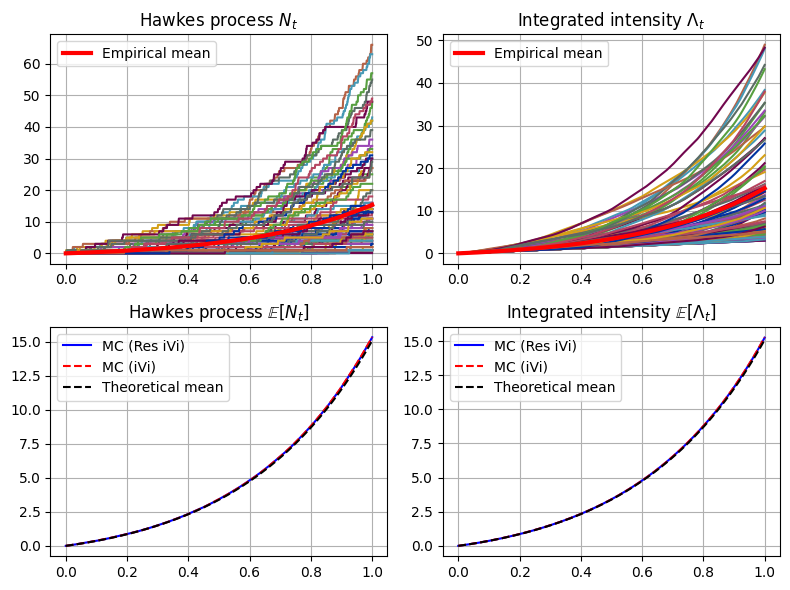

In [9]:
n_show = 100
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(t_grid, N[:, 0:n_show])
ax[0, 0].plot(t_grid, N.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 0].set_title('Hawkes process $N_t$')
ax[0, 0].legend()
ax[0, 0].grid("on")

ax[0, 1].plot(t_grid, U[:,0:n_show])
ax[0, 1].plot(t_grid, U.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 1].set_title('Integrated intensity $\Lambda_t$')
ax[0, 1].legend()
ax[0, 1].grid("on")

ax[1, 0].plot(t_grid, N_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 0].plot(t_grid, N.mean(axis=1), "r--", label="MC (iVi)")
ax[1, 0].plot(t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 0].set_title('Hawkes process $\mathbb{E}[N_t]$')
ax[1, 0].legend()
ax[1, 0].grid("on")

ax[1, 1].plot(t_grid, U_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 1].plot(t_grid, U.mean(axis=1), "r--", label="MC (iVi)")
ax[1, 1].plot(t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 1].set_title('Integrated intensity $\mathbb{E}[\Lambda_t]$')
ax[1, 1].legend()
ax[1, 1].grid("on")

plt.show()

# Simulation of arrival times

In [10]:
# Specify the kernel
lam = 1.1
alpha = 2.5
K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)

T = 10
n_steps = 300
t_grid = np.linspace(0, T, n_steps + 1)

n_paths = 1

ivi_hawkes = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=np.random.default_rng(seed = 42), g0=g0_const, resolvent_flag=False)
ivi_hawkes_res = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, g0_bar_res=g0_bar_res, rng=np.random.default_rng(seed = 42),
                                  g0=g0_const, resolvent_flag=True)

In [11]:
%%time
# Simulate arrivals times using the `simulate_arrivals` method
N_jumps = ivi_hawkes.simulate_arrivals(t_grid=t_grid, n_paths=n_paths)
N_jumps_res = ivi_hawkes_res.simulate_arrivals(t_grid=t_grid, n_paths=n_paths)

CPU times: total: 281 ms
Wall time: 330 ms


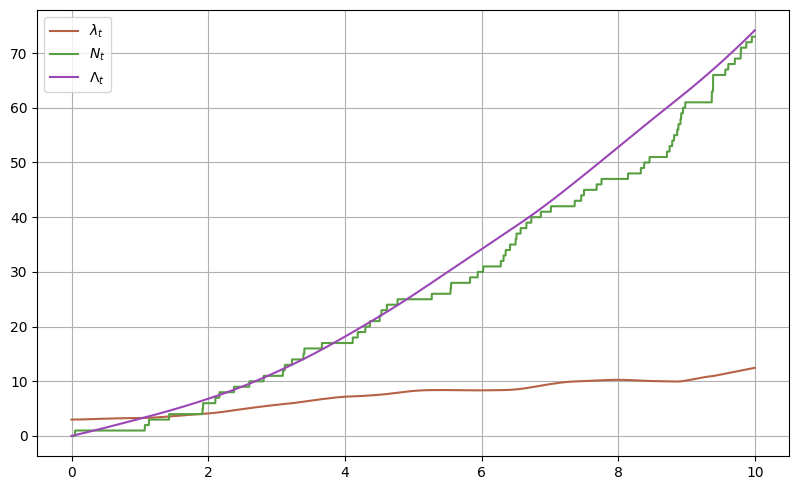

In [16]:
idx = 0

# Plot the jumps using a finer grid
t_grid_fine = np.linspace(0, T, 10**4)
plt.plot(t_grid_fine, lam_from_jumps(t_grid_fine, N_jumps[idx], kernel=ivi_hawkes.kernel, g0=ivi_hawkes.g0), label="$\lambda_t$")
plt.plot(t_grid_fine, N_from_jumps(t_grid_fine, N_jumps[idx]), label="$N_t$")
plt.plot(t_grid_fine, U_from_jumps(t_grid_fine, N_jumps[idx], kernel=ivi_hawkes.kernel, g0_bar=ivi_hawkes.g0_bar), label="$\Lambda_t$")
plt.legend()
plt.show()

Kolmogorov-Smirnov test p-value:  0.8591849461445373
Kolmogorov-Smirnov test p-value:  0.8591849461445373


(0.8591849461445373, 0.06855284865483713)

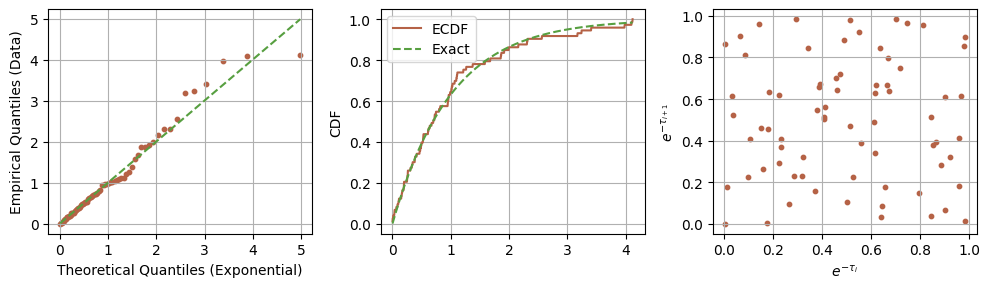

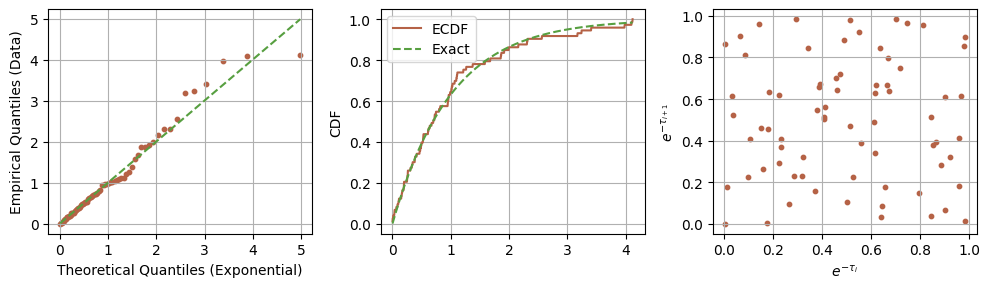

In [21]:
# Evaluating the integrated variances in the arrival times
U_tau = U_from_jumps(N_jumps[idx], N_jumps[idx], kernel=ivi_hawkes.kernel, g0_bar=ivi_hawkes.g0_bar)
U_tau_res = U_from_jumps(N_jumps_res[idx], N_jumps_res[idx],  kernel=ivi_hawkes_res.kernel, g0_bar=ivi_hawkes_res.g0_bar)
# Check the distribution of arrivals
poisson_jumps_test(U_tau)
poisson_jumps_test(U_tau_res)